# No Show Appts Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#questions">Questions</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
#### From Udacity
> This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
> 
>        ● "ScheduledDay" tells us on what day the patient set up their appointment. 
>        ● "Neighborhood" indicates the location of the hospital. 
>        ● "Scholarship" indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família. 
>        ● Be careful about the encoding of the last column: it says "No" if the patient showed up to their appointment, and "Yes" if they did not show up.
>
> <br>
> What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?
>

#### From [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments) 

We can define the fields in our data as 

* PatientId - Identification of a patient
* AppointmentID - Identification of each appointme
* Gender - Male or Female . Female is the greater proportion, woman takes way more care of they health in comparison to man.
* ScheduledDay - The day of the actual appointment, when they have to visit the doctor.
* AppointmentDay - The day someone called or registered the appointment, this is before appointment of course.
* Age - How old is the patient.
* Neighbourhood - Where the appointment takes place.
* Scholarship - True of False - *recipient of some sort of government welfare*
* Hipertension - True or False
* Diabetes - True or False
* Alcoholism - True or False
* Handcap - True or False
* SMS_received - 1 or more messages sent to the patient.
* No-show - True or False


<a id='questions'></a>
## Questions

What questions are we seeking to answer in this analysis? There are 6 main questions:

* Is there a proclivity for a certain gender to schedule their appts more than the other?
* Can someone's age play a role in missing an appt?
* Does the patient's well-being or medical issues (diabetes/alcoholism/hypertension) have an impact on the probability of an appt being missed?
* Does a text reminder have an impact on an appt being missed?
* Does the location of the office matter?
* Does the month of day of the week play a role?


<a id='wrangling'></a>
## Data Wrangling

Let's start with our imports and data pull.

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

In [205]:
df = pd.read_csv('appts.csv')
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


We should drop `PatiendId` and  `AppointmentID` as they are not critical to our analysis and future modeling. But before we do that let's check if we have duplicate records including those features.

In [206]:
df.duplicated().sum()

0

Ok we can go ahead and drop these columns.

In [207]:
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)
df.head(2)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


Let's convert our date fields to datetime.

In [208]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

Now let's check the data types we have so far. Additionally we see that we have no null fields.

In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   Gender          110527 non-null  object             
 1   ScheduledDay    110527 non-null  datetime64[ns, UTC]
 2   AppointmentDay  110527 non-null  datetime64[ns, UTC]
 3   Age             110527 non-null  int64              
 4   Neighbourhood   110527 non-null  object             
 5   Scholarship     110527 non-null  int64              
 6   Hipertension    110527 non-null  int64              
 7   Diabetes        110527 non-null  int64              
 8   Alcoholism      110527 non-null  int64              
 9   Handcap         110527 non-null  int64              
 10  SMS_received    110527 non-null  int64              
 11  No-show         110527 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(7), object(3)
memory usage: 10.1+ MB


Looks like `No-Show` should really be a bit flag. Let's validate all the possible values and then change "yes" to 1 and "no" to 0.

In [210]:
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [211]:
df['No-show'] = df['No-show'].apply(lambda x: 1 if x=='Yes' else 0)
df.head(2)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0


Now let's update our column names by doing the following. 

* Make all lowercase
* replace "-" with "_"
* add underscores to `scheduledday` and `appointmentday`
* rename `scholarship` to `govt_assist`
* rename `handcap` to `handicap`
* rename `hipertension` to `hypertenseion`
* rename `neighbourhood` to `office_location`

Let's start with the first two bullet points.

In [212]:
df.columns = [col.lower().replace('-','_') for col in df.columns]
df.head(2)

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0


Now let's add underscores where needed.

In [213]:
df.rename({'scheduledday':'scheduled_day', 'appointmentday':'appointment_day'},axis=1,inplace=True)
df.head(2)

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0


Lastly let's rename the columns in the last four bullet points. We are just doing this so it is clear with these features are.

In [214]:
df.rename({'scholarship':'govt_assist', 'handcap':'handicap', 'hipertension':'hypertension', 'neighbourhood':'office_location'},axis=1,inplace=True)
df.head(2)

,gender,scheduled_day,appointment_day,age,office_location,govt_assist,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0


We now have established our dataset. Let's make sure we see the data we expect. Let's start with `age`.

In [215]:
# min max of age
df['age'].min(), df['age'].max()

(-1, 115)

Right off the bat we see that age has some funky numbers. We can't for sure say 115 is wrong. The oldest person that ever lived was 122. The -1 is cleary wrong. We could apply a mean value but this could be erroneous since the mean would make a potential child an adult. Let's see how many of these odd values we have.

In [216]:
(df[df['age']<0].value_counts().shape[0] / df.shape[0])*100

0.0009047563038895474

So less than 1% of our data consists of a -1. Let's just drop them.

In [217]:
df = df.drop(df[df['age']<0].index, axis=0)

In [218]:
(df[df['age']<0].value_counts().shape[0] / df.shape[0])*100

0.0

Now let's check our dates. We also want to make sure that `appointment_day` can't be before `scheduled_day`. Let's disregard the time component as it appears that `appointment_day` doesn't have a time component. Let's work strictly with dates.

In [219]:
# min max of scheduled_day
df['scheduled_day'].min(), df['scheduled_day'].max()

(Timestamp('2015-11-10 07:13:56+0000', tz='UTC'),
 Timestamp('2016-06-08 20:07:23+0000', tz='UTC'))

In [220]:
# min max of scheduled_day
df['appointment_day'].min(), df['appointment_day'].max()

(Timestamp('2016-04-29 00:00:00+0000', tz='UTC'),
 Timestamp('2016-06-08 00:00:00+0000', tz='UTC'))

In [221]:
# checking if appt day is less than sched day
((df['appointment_day'].dt.date < df['scheduled_day'].dt.date).sum()/df.shape[0])*100

0.004523822449016521

So .4% of the appointments are before the day the person called to schedule it. This certainly doesn't make sense. How can you schedule an appt for the past? There is no way that is possible so we are going to drop these.

In [222]:
df = df[df['appointment_day'].dt.date >= df['scheduled_day'].dt.date]

Lastly, let's make sure our bit flag features really only have 1 or a 0.

In [223]:
bit_flag_cols = ['govt_assist',	'hypertension',	'diabetes',	'alcoholism',	'handicap',	'sms_received',	'no_show']
for col in bit_flag_cols:
    print(col)
    print(df[col].value_counts())
    print()

govt_assist
0    99660
1    10861
Name: govt_assist, dtype: int64

hypertension
0    88720
1    21801
Name: hypertension, dtype: int64

diabetes
0    102578
1      7943
Name: diabetes, dtype: int64

alcoholism
0    107161
1      3360
Name: alcoholism, dtype: int64

handicap
0    108282
1      2040
2       183
3        13
4         3
Name: handicap, dtype: int64

sms_received
0    75039
1    35482
Name: sms_received, dtype: int64

no_show
0    88207
1    22314
Name: no_show, dtype: int64



Ok, so it turns out that `handicap` has some unexpected numbers. We can either convert 2,3,4 to a 1 considering they are all over 1, or we can drop these records. I think its ok to call these 1s considering that only about 1.8% of the records are a 1.

In [224]:
df['handicap'] = df['handicap'].apply(lambda x: 1 if x>1 else x)

In [225]:
df['handicap'].value_counts()

0    108282
1      2239
Name: handicap, dtype: int64

Now let's check the only categorical feature in our data to see if there is anything we need to correct. Let's sort the values alphabetically and check if there are any slight misspellings that might be causing more distinct values than actually needed.

In [226]:
sorted(df['office_location'].unique())

['AEROPORTO',
 'ANDORINHAS',
 'ANTÔNIO HONÓRIO',
 'ARIOVALDO FAVALESSA',
 'BARRO VERMELHO',
 'BELA VISTA',
 'BENTO FERREIRA',
 'BOA VISTA',
 'BONFIM',
 'CARATOÍRA',
 'CENTRO',
 'COMDUSA',
 'CONQUISTA',
 'CONSOLAÇÃO',
 'CRUZAMENTO',
 'DA PENHA',
 'DE LOURDES',
 'DO CABRAL',
 'DO MOSCOSO',
 'DO QUADRO',
 'ENSEADA DO SUÁ',
 'ESTRELINHA',
 'FONTE GRANDE',
 'FORTE SÃO JOÃO',
 'FRADINHOS',
 'GOIABEIRAS',
 'GRANDE VITÓRIA',
 'GURIGICA',
 'HORTO',
 'ILHA DAS CAIEIRAS',
 'ILHA DE SANTA MARIA',
 'ILHA DO BOI',
 'ILHA DO FRADE',
 'ILHA DO PRÍNCIPE',
 'ILHAS OCEÂNICAS DE TRINDADE',
 'INHANGUETÁ',
 'ITARARÉ',
 'JABOUR',
 'JARDIM CAMBURI',
 'JARDIM DA PENHA',
 'JESUS DE NAZARETH',
 'JOANA D´ARC',
 'JUCUTUQUARA',
 'MARIA ORTIZ',
 'MARUÍPE',
 'MATA DA PRAIA',
 'MONTE BELO',
 'MORADA DE CAMBURI',
 'MÁRIO CYPRESTE',
 'NAZARETH',
 'NOVA PALESTINA',
 'PARQUE INDUSTRIAL',
 'PARQUE MOSCOSO',
 'PIEDADE',
 'PONTAL DE CAMBURI',
 'PRAIA DO CANTO',
 'PRAIA DO SUÁ',
 'REDENÇÃO',
 'REPÚBLICA',
 'RESISTÊNCIA',
 'RO

Looks like we are good. Let's check the head of the dataframe and spot check info() one more time.

In [227]:
df.head()

,gender,scheduled_day,appointment_day,age,office_location,govt_assist,hypertension,diabetes,alcoholism,handicap,sms_received,no_show
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   gender           110521 non-null  object             
 1   scheduled_day    110521 non-null  datetime64[ns, UTC]
 2   appointment_day  110521 non-null  datetime64[ns, UTC]
 3   age              110521 non-null  int64              
 4   office_location  110521 non-null  object             
 5   govt_assist      110521 non-null  int64              
 6   hypertension     110521 non-null  int64              
 7   diabetes         110521 non-null  int64              
 8   alcoholism       110521 non-null  int64              
 9   handicap         110521 non-null  int64              
 10  sms_received     110521 non-null  int64              
 11  no_show          110521 non-null  int64              
dtypes: datetime64[ns, UTC](2), int64(8), object(2)
memory usag

<a id='eda'></a>
## Exploratory Data Analysis

Let's get started with the fun stuff. The goal here is to explore our clean data and make sure that we head in the right direction of answering our questions.

The key metric we are going to be using here is `No Show Ratio`

$$\text{no show ratio} = \frac{\text{no shows appts}}{\text{total appts}}$$

Firstly, let's explore gender and look at a no-show ratio. We'll copy the initial dataframe in case we need to make modifications, for example I am going to add a count field to make some math easier.

In [229]:
df_clean = df.copy()
df_clean['count'] = 1

def group_and_plot(groupby, size=(8,6)):
    tmp = df_clean.groupby(groupby).sum().reset_index()
    #all_no_shows = tmp['no_show'].sum()
    tmp[groupby] = tmp[groupby].astype(str)
    tmp['no_show_ratio'] = tmp['no_show']/tmp['count']
    print(tmp[[groupby,'no_show_ratio']].sort_values('no_show_ratio', ascending=False))
    plt.figure(figsize=size)
    plt.bar(tmp[groupby], tmp['no_show_ratio'])
    plt.title(f'{groupby} - No Show Ratio Comparison')
    plt.xlabel(groupby)
    plt.xticks(rotation=45)
    plt.ylabel('no_show_ratio')
    
def group_and_plot_pie(groupby, size=(8,6), top_x=None):
    tmp = df_clean.groupby(groupby).sum()
    all_no_shows = tmp['no_show'].sum()
    tmp['no_show_proportion'] = tmp['no_show']/all_no_shows
    if top_x:
        tmp = tmp.sort_values('no_show_proportion', ascending=False).iloc[0:top_x]
    print(tmp[['no_show_proportion']].sort_values('no_show_proportion', ascending=False))
    plt.figure(figsize=size)
    tmp['no_show_proportion'].plot.pie(autopct="%.1f%%");
    plt.title(f'{groupby} No Show Proportion')
    plt.xlabel(groupby)
    plt.ylabel('no_show_proportion')
    

  gender  no_show_ratio
0      F       0.203115
1      M       0.199638


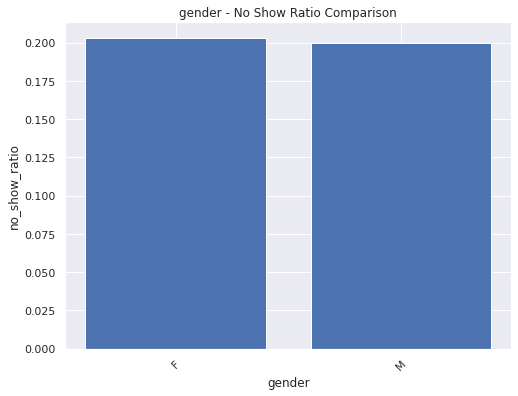

In [230]:
group_and_plot('gender')

So we can clearly see there is no major difference between the 2. Wonder if there is some age dependence. Let's first look at age on its own, then we can meld it with gender. Let's first add an age bin.

In [231]:
def age_binning(age):
    if age >=0 and age<=12:
        return 'child'
    if age>12 and age<=19:
        return 'teenager'
    if age>19 and age<=64:
        return 'adult'
    return 'senior'

df_clean['age_cat'] = df_clean['age'].apply(age_binning)
df_clean.head(2)

,gender,scheduled_day,appointment_day,age,office_location,govt_assist,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,count,age_cat
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,1,adult
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,1,adult


    age_cat  no_show_ratio
3  teenager       0.259548
1     child       0.204706
0     adult       0.203056
2    senior       0.154989


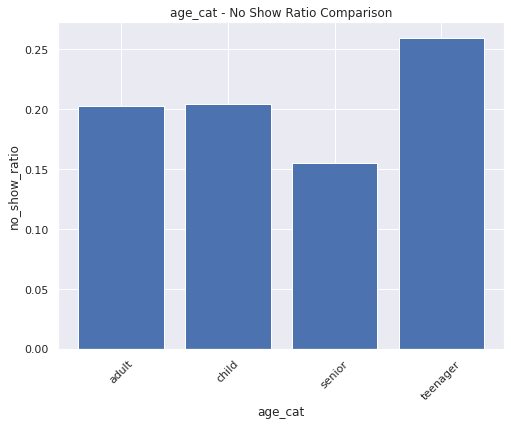

In [232]:
group_and_plot('age_cat')

          no_show_proportion
age_cat                     
adult               0.597965
child               0.192973
teenager            0.109035
senior              0.100027


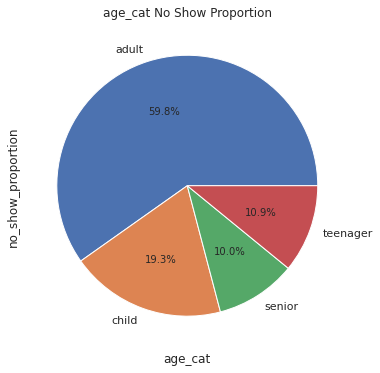

In [233]:
group_and_plot_pie('age_cat')

We see that teenagers tend to miss their appts more and seniors are more apt to make their appts. With this being true, we see that adults make up a larger portion of the total dataset. If we consider no shows divided by total appts then teenager is highest. If we consider no shows divided by total no shows then adults have the higher number. This means that the dataset has more adults than teenagers.

In [234]:
df_clean['age_cat'].value_counts()

adult       65711
child       21035
senior      14401
teenager     9374
Name: age_cat, dtype: int64

What if we blend age and gender? Looks look at the distributions of age for no shows for both genders. Let's additionally check proptions of M and F we are dealing with.

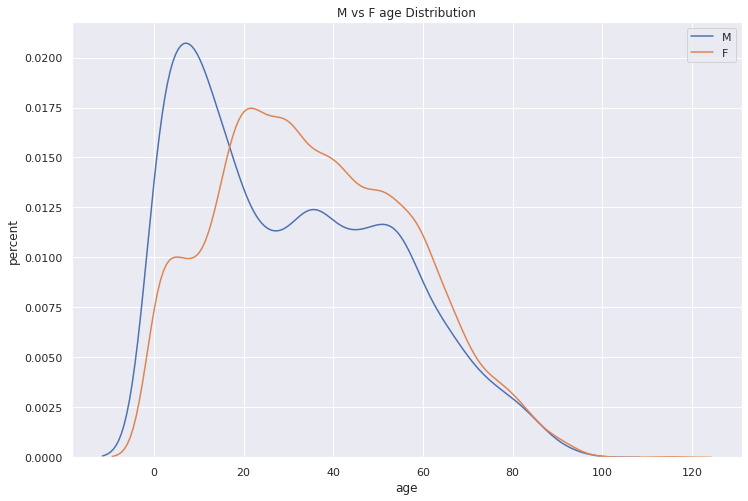

In [235]:
tmp = df_clean[(df_clean['no_show']==1)]
plt.figure(figsize=(12,8))
sns.kdeplot(tmp[tmp['gender']=='M']['age'], label='M')
sns.kdeplot(tmp[tmp['gender']=='F']['age'], label='F')
plt.title('M vs F age Distribution')
plt.xlabel('age')
plt.ylabel('percent')
plt.legend()
plt.show()

In [236]:
df_clean['gender'].value_counts()

F    71836
M    38685
Name: gender, dtype: int64

It appears that we are more heavily weighted on females in this dataset. With what we have, females who miss appts tend to be younger than males who miss appts.

Now let's check out the day of the week and the month for scheduled appts.

In [237]:
df_clean['month'] = df_clean['scheduled_day'].dt.month
df_clean['day_of_week'] = df_clean['scheduled_day'].dt.weekday

  month  no_show_ratio
2     3       0.330935
7    12       0.311475
3     4       0.309760
0     1       0.300000
1     2       0.291815
4     5       0.174499
5     6       0.100807
6    11       0.000000


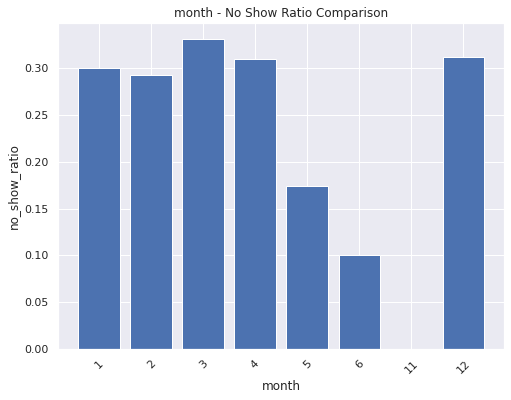

In [238]:
group_and_plot('month');

This is pretty remarkable. The no show ratio takes a big dip in the summer months. Let's make sure we even have that data.

In [239]:
df_clean[df_clean['month'].isin([7,8,9,10,11])]

,gender,scheduled_day,appointment_day,age,office_location,govt_assist,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,count,age_cat,month,day_of_week
3764,F,2015-11-10 07:13:56+00:00,2016-05-04 00:00:00+00:00,51,RESISTÊNCIA,0,0,0,0,0,1,0,1,adult,11,1


So it turns out we don't. For the months we do have (December through June), it appears March, December then April are the biggest months for no shows. Now let's turn our attention to day of week.

  day_of_week  no_show_ratio
4           4       0.205498
3           3       0.204681
1           1       0.202163
2           2       0.200998
0           0       0.197583
5           5       0.041667


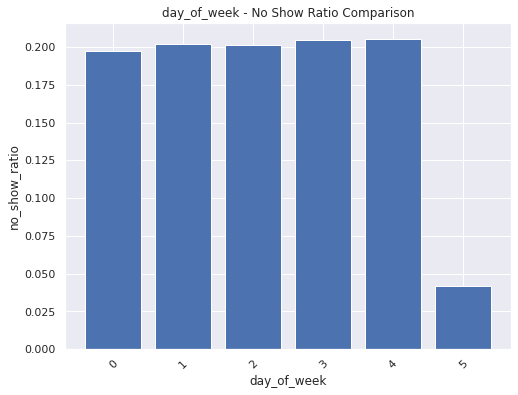

In [240]:
group_and_plot('day_of_week');

Friday slightly has the higher no show ratio but its pretty negligble. We see that they offer some Saturday appts. Considering this is on the weekend it makes sense that the no show ratio is very low.

Now let's check out government assistance. We see that those on government assistance have a higher no show ratio. 

  govt_assist  no_show_ratio
1           1       0.237363
0           0       0.198033


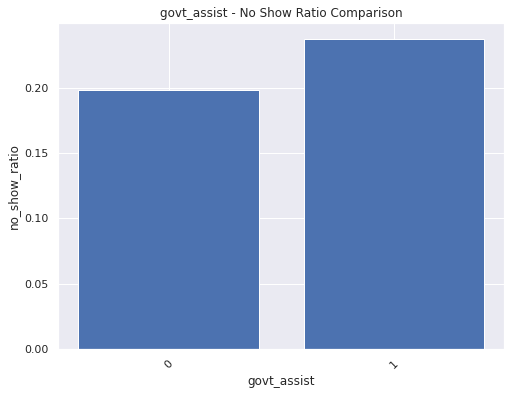

In [241]:
group_and_plot('govt_assist');

What about whether or not someone receives an SMS message? Remarkably those who get an SMS message tend to miss more appointments.

  sms_received  no_show_ratio
1            1       0.275745
0            0       0.166980


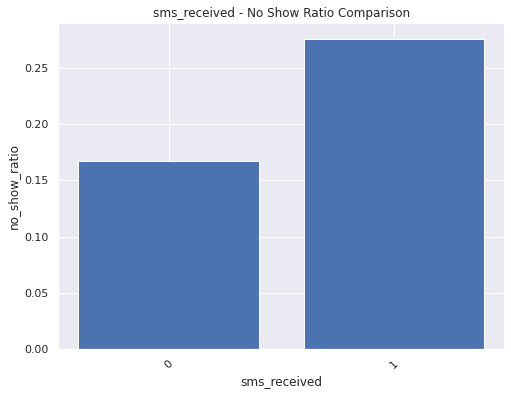

In [242]:
group_and_plot('sms_received');

So far, our result is that a teenager who is on government assistance and receives an sms reminder with a set appt in March is the most likely person to miss their appt.

We need to wonder if their is an age dynamic to this. Do older people not sign up for SMS?

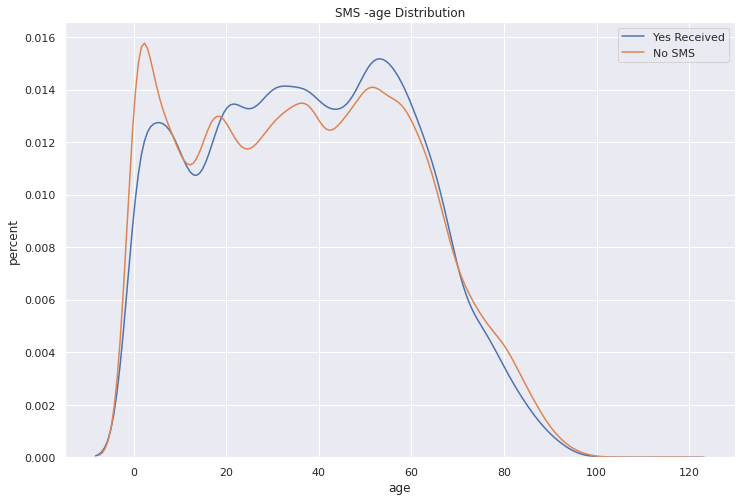

In [243]:
plt.figure(figsize=(12,8))
sns.kdeplot(df_clean[df_clean['sms_received']==1]['age'], label='Yes Received')
sns.kdeplot(df_clean[df_clean['sms_received']==0]['age'], label='No SMS')
plt.title('SMS -age Distribution')
plt.xlabel('age')
plt.ylabel('percent')
plt.legend()
plt.show()

Quite suprisinly there isn't really a big difference across age.

Now let's look at health conditions and well-being. Here we will sum across these 4 categories -  diabetes, handicap, alcoholism and hypertension. The higher the number the more health issues or issues with well-being someone has.

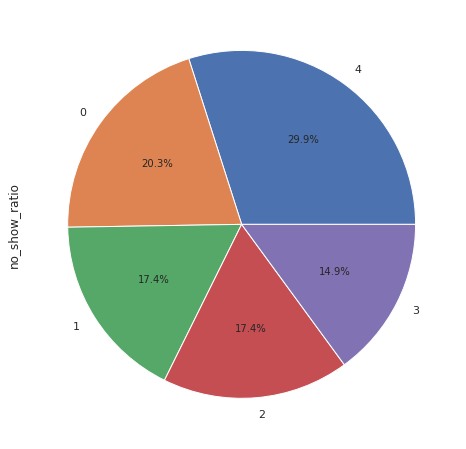

In [244]:
df_clean['poor_health'] = df_clean['diabetes'] + df_clean['hypertension'] + df_clean['handicap'] + df_clean['alcoholism']
tmp = df_clean.groupby('poor_health').sum()
tmp['no_show_ratio'] = tmp['no_show']/tmp['count']
tmp2 = tmp.sort_values('no_show_ratio', ascending=False).iloc[0:20]

plt.figure(figsize=(12,8))
tmp2['no_show_ratio'].plot.pie(autopct="%.1f%%");

We see that poor health or well-being plays a major role in missing appts if you have all four of these conditions. Let's see how much of this dataset this is.

In [245]:
df_clean['poor_health'].value_counts()

0    84111
1    18121
2     7658
3      618
4       13
Name: poor_health, dtype: int64

We see that have all four conditions is very rare, so it is tough to place a lot of creditability on the no show ratio with such a low amount of samples for that sub-category especially where the other subcategories of combined health issues (1,2,3) are lower than the no show ratio of subcategory 0.

Now let's consider people who have one or more health/well-being issues. What does the age distribution look like?

In [ ]:
tmp = df_clean[(df_clean['no_show']==1) & (df_clean['poor_health']==1)]
plt.figure(figsize=(12,8))
sns.swarmplot(x='poor_health', y='age', data=tmp)
plt.axhline(y=tmp['age'].mean(), color='r', linestyle='--')
plt.title('Health/Well-Being No Shows - Age Distribution')
plt.show();

/opt/conda/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


We can see the the bulk of the data lies between 40 and 80 years of age where the mean is around 55 years of age. This is in contrast with teenagers who in general have the highest ratio of missed appts, but when not entirely healthy it is those around 55 years of age that miss the most.

Now let's see what office location looks like. Let's see how the top 20 highest no show ratio locations compare.

In [ ]:
#group_and_plot('office_location',(20,10));
tmp = df_clean.groupby('office_location').sum()
tmp['no_show_ratio'] = tmp['no_show']/tmp['count']
tmp2 = tmp.sort_values('no_show_ratio', ascending=False).iloc[0:20]
tmp2[['no_show_ratio','count']]

## Conclusion
<a id='conclusions'></a>

We've cleaned our data and walked through some analysis of the features. Let's answer the following questions.

* Is there a proclivity for a certain gender to schedule their appts more than the other?
    * There is no major difference between the two genders in this dataset when it comes to the ratio of missed appts but the dataset as a whole is heavily skewed towards female.
* Can someone's age play a role in missing an appt?
    * Age does seem to be an indicator of a higher chance of being a no show. Teenage patients have a no show ratio of 26% which is the highest out of the four categories of child, teenager, adult and senior. Seniors were the most adherent to their appts. The adult bucket when it comes to proportion of total no shows is the highest by far but this is because that is the largest bucket. Female leaned towards younger people missing their appts where males where yound adults on average.
* Does the patient's well-being or medical issues (diabetes/alcoholism/hypertension) have an impact on the probability of an appt being missed?
    * This did not seem to make a difference. Actually, it seemed the healthiest people (at least on these 4 categories) were more likely to miss their appt than those with 1,2 or 3 of the conditions. There were a minimal number of people with all 4 conditions and that no show ratio was very high, but with a very low sample of those people it is hard to conclude that the value is an anomoly or not. It seems on the surface, the healthiest tend to miss more appts than those who are not. Those who had one or more issues and missed an appt were on average around 55 years of age.
* Does a text reminder have an impact on an appt being missed?
    * Suprisingly, those who received text reminders had a no show ratio of over 10 points higher than those who didn't.
* Does the location of the office matter?
    * We see that it is very variable and its hard to draw conclusions with so many different areas. If we knew more about this area of the word we could categorgize these (like categorizing cities to states in the US, or suburbs to cities). This would need further investigation. 
* Does the month of day of the week play a role?
    * We don't have all months of the year represented in the data but March is the month with the largest no show ratio. As for day of the week, it didn't make a big difference the day of the week M-F however people were very adherent to their weekend appts. 
    
    
This problem is a supervised learning problem (classification). We are dealing with sample data here and there things I noticed during the analysis that could use some attention before predicting liklihood of missed appts.
* Far more female data than male (65% to 35%)
* Heavily skewed towards adults (19 to 65 years of age) however we could break those up into smaller buckets
* Months missing from the dataset
* Higher grain of detail on location and population

